# Classic computer vision

## QR CODE (suggested algorighm)

https://www.swisseduc.ch/informatik/theoretische_informatik/qr_codes/docs/qr_standard.pdf

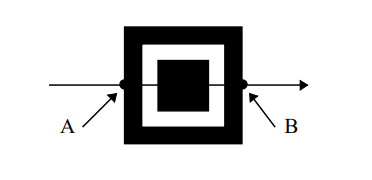

1.  Determine a Global Threshold by taking a reflectance value midway between the maximum reflectance and
    minimum reflectance in the image. Convert the image to a set of dark and light pixels using the Global
    Threshold.

2.  Locate the Finder Pattern. The finder pattern in QR Code consists of three identical Position Detection
    Patterns located at three of the four corners of the symbol. As described in 7.3.2, module width in each
    Position Detection Pattern is constructed of a dark-light-dark-light-dark sequence the relative widths of each
    element of which are in the ratios 1:1:3:1:1. For the purposes of this algorithm the tolerance for each of these
    widths is 0,5 (i.e. a range of 0,5 to 1,5 for the single module box and 2,5 to 3,5 for the three module square
    box).
    
    
# OTSU thresholding

We will determine the threshold by using the Otsu algorithm. The threshold is determined by minimizing intra-class intensity variance of pixel intensities.

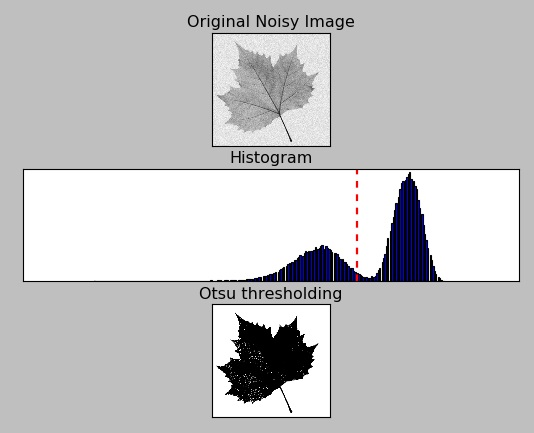


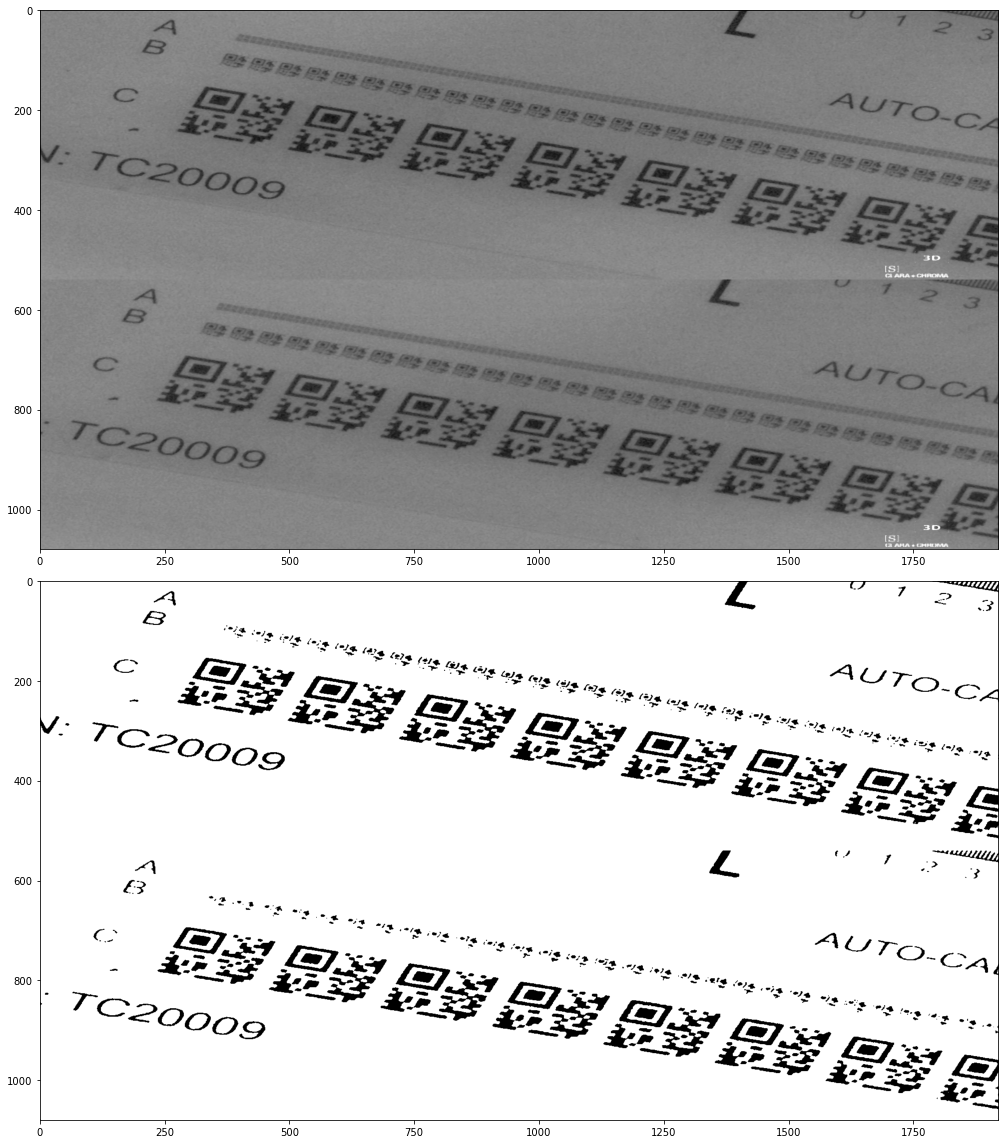

In [1]:
# load image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import affine_transform, gaussian_filter
from scipy.signal import medfilt
from skimage import data, exposure, filters
from scipy.ndimage.measurements import label
from scipy.ndimage import gaussian_filter as G
from scipy.ndimage import sobel as S
from skimage import transform
from sklearn.cluster import DBSCAN
import numpy as np

im = Image.open("Ch2_016_S.png")

Image = medfilt(np.asarray(im).mean(axis=-1))
val = filters.threshold_otsu(Image[::2,::2])
I = (Image > (val-10)).astype(np.float)


fig,axs = plt.subplots(2,1, figsize=[16,16])

axs[0].imshow(Image, cmap='gray')
axs[1].imshow(I, cmap='gray')

plt.tight_layout()

In [2]:
def QR_Finders(I, tol=0.5, min_width=20):
    H,W = I.shape
    I[:,0] = 0
    I[:,-1] = 0
    candidates = [ ] 
    for i in range(0,H):
        Ix_i =  I[i,:][1:] - I[i,:][:-1]
        up_j = np.argwhere(Ix_i==1)
        if len(up_j) == 1: continue
        up_j = up_j.squeeze()
        dwn_j = np.argwhere(Ix_i==-1).squeeze()
        w = dwn_j-up_j
        b = up_j[1:] - dwn_j[:-1]
        starts = dwn_j[:-1]
        ends = up_j[1:]
        for j in range(1,len(b)-1):
            if b[j] < min_width: continue
            is_finder = 3.0-tol < b[j]/w[j+1] < 3.0 +tol
            is_finder = 3.0-tol < b[j]/w[j] < 3.0 + tol and is_finder
            is_finder = 1.-tol< b[j-1]/w[j] < 1.+tol and is_finder
            is_finder = 1.-tol< b[j+1]/w[j+1] < 1.+tol and is_finder
            if is_finder:
                A = starts[j-1]
                B = ends[j+1]
                candidates += [ [i,A,B] ]
    return candidates

candidates = QR_Finders(I)

# QR Finders

Implement step 2 of proposed algorithm to extract point A and B.


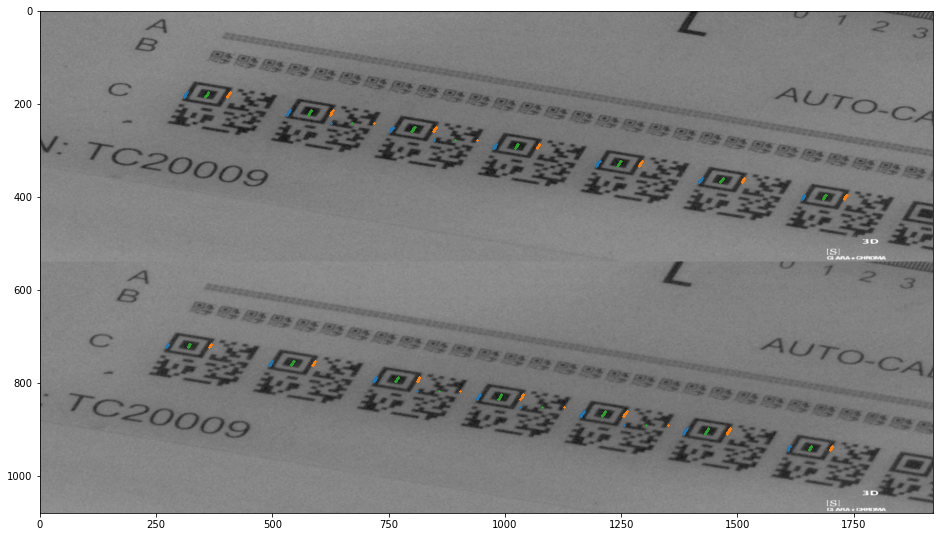

In [3]:

fig,axs = plt.subplots(1,1, figsize=[16,16])

axs.imshow(Image, cmap='gray')
scatter_x = [ col for col,A,B in candidates ]
scatter_y = [ A for col,A,B in candidates ]
axs.scatter(scatter_y, scatter_x, marker='x', s=2)
scatter_y = [ B for col,A,B in candidates ]
axs.scatter(scatter_y, scatter_x, marker='x', s=2)
scatter_y = [ (A+B)/2. for col,A,B in candidates ]
axs.scatter(scatter_y, scatter_x, marker='x', s=2)

## Clustering

We will proceed to cluster each nearby detection to identity a single pattern using a density based clustering algorithm (DBSCAN).

It's complexity is $O(n^2)$ wher n is the number of features points, these are aggregated based on a pairwise distance matrix.

The features used in this context are the center coodrindates and the width.

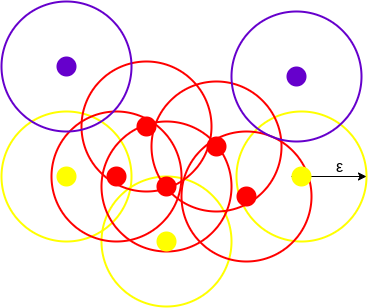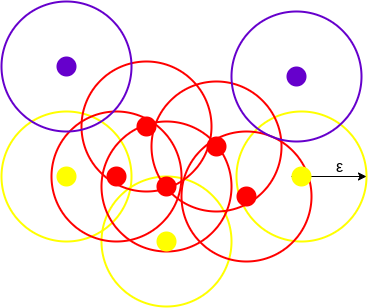

In [4]:
# Cluster candidate samples and remove those that do not belong to clusters with at least 3 samples
# generate 3D feature points (center_i, center_j, width)

def get_clusters(candidates):
    X = np.array( [ [row, (strat+end)/2, end-strat]  for row,strat,end in candidates ] )
    Xw = (X - X.mean())/ X.std()
    clustering = DBSCAN(eps=0.1, min_samples=3).fit(Xw)
    clusters = [ X[clustering.labels_==c].mean(axis=0) for c in range(np.max(clustering.labels_)+1) ]
    return clusters

clusters = get_clusters(candidates)

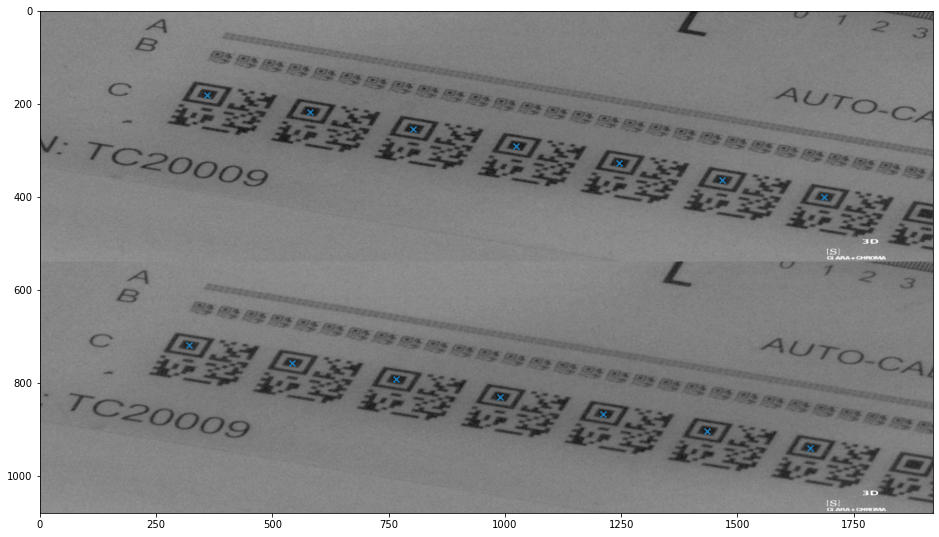

In [5]:

fig,axs = plt.subplots(1,1, figsize=[16,16])

axs.imshow(Image, cmap='gray')
scatter_x = [ cx for cx,cy,w in clusters ]
scatter_y = [ cy for cx,cy,w in clusters ]
axs.scatter(scatter_y, scatter_x, marker='x')


In [6]:

def HarrisCornerDetector(I, k=0.05, w=3):
    Ix,Iy = S(I,axis=0),S(I,axis=1)
    M = [ G(Ix**2,w), G(Iy**2,w), G(Ix*Iy,w) ]
    traceM = M[0] + M[1]
    detM = M[0]*M[1] - M[2]**2
    R = detM - k*(traceM)**2
    return R

def orderCorners(corners):
    ordered_corners = np.zeros([4,2])
    for c in corners:
        d = np.sign(c-corners)
        updwn = d[:,0].sum()
        lr = d[:,1].sum()
        if updwn < 0 and lr < 0:
            ordered_corners[0,:] = c
        if updwn < 0 and lr > 0:
            ordered_corners[3,:] = c
        if updwn > 0 and lr > 0:
            ordered_corners[2,:] = c
        if updwn > 0 and lr < 0:
            ordered_corners[1,:] = c
    return ordered_corners

def computeAffine(ordered_corners):

    x0,y0 = np.array([-3,-3])
    x1,y1 = np.array([3,-3])
    x2,y2 = np.array([3,3])
    x3,y3 = np.array([-3,3])

    u0,v0 = ordered_corners[0]
    u1,v1 = ordered_corners[1]
    u2,v2 = ordered_corners[2]

    A = [[x0, y0, 1, 0, 0, 0, ],
         [x1, y1, 1, 0, 0, 0, ],
         [x2, y2, 1, 0, 0, 0, ],
         [0, 0, 0, x0, y0, 1, ],
         [0, 0, 0, x1, y1, 1, ],
         [0, 0, 0, x2, y2, 1, ],
        ]

    b = [ u0,u1,u2,v0,v1,v2 ]

    x = np.linalg.solve(A, b)
    M = [ [x[0],x[1],x[2]],
          [x[3],x[4],x[5]],
          [0.,0.,1.] ]
    M = np.array(M)
    return M

def extractCorners(I, clusters):
    # extrapolated corners
    x0,y0 = np.array([-10,-10])
    x1,y1 = np.array([30,-10])
    x2,y2 = np.array([30,30])
    x3,y3 = np.array([-10,30])

    p0 = np.array([x0,y0,1])
    p1 = np.array([x1,y1,1])
    p2 = np.array([x2,y2,1])
    p3 = np.array([x3,y3,1])

    P = np.array([p0,p1,p2,p3])
    
    BBox = []
    Trans = []
    for i in range(len(clusters)):
        # each cluste corresponds to a code we will extract the first one to provide an input to a decoder 
        col,row,width = clusters[i].round().astype(int)
        # by construction the center should be inside a blak square we will therfore extract 
        # the central connected component and run corner detection to detect 4 angles.
        sub_I = I[col-width//2:col+width//2, row-width//2:row+width//2]
        label_sub_I = label(1-sub_I)[0]
        label_center = label_sub_I[width//2, width//2]
        center_cc = (label_sub_I!=label_center).astype(np.float32)
        corner_sub_I = HarrisCornerDetector(center_cc)
        corner_candidates = np.argwhere(corner_sub_I>0.9)

        clustering = DBSCAN(eps=6, min_samples=4).fit(corner_candidates)
        cluster_sizes = np.array([ sum(clustering.labels_==c) for c in range(np.max(clustering.labels_)+1) ])
        size_inidices = np.argsort(cluster_sizes)
        corners = np.array([ corner_candidates[clustering.labels_==c].mean(axis=0) for c in range(np.max(clustering.labels_)+1) ])[size_inidices[::-1]][:4]
        corners = orderCorners(corners)
        M = computeAffine(corners)#*0.9 + computePerspective(corners)*0.1
        Trans += [M]
        
        Pp = (M@P.T).T
        Pp/=Pp[:,-1:]
        Pp = Pp[:,:-1]
        
        Pp_I = Pp*1.
        Pp_I[:,0] += col-width//2
        Pp_I[:,1] += row-width//2
        
        BBox += [Pp_I]
        
    return BBox, corners, label_sub_I, center_cc, corner_sub_I, sub_I, M, Pp, Pp_I
    
BBox, corners, label_sub_I, center_cc, corner_sub_I, sub_I, M, Pp, Pp_I = extractCorners(I, clusters)



# Corner detection and affine transformation 

The algorithm extract the pattern by detecting the 4 cournes of the finder.

1) extract the sub image corresponding to the detected center and width.
2) compute connected components to isolate innmost square
3) Aggregate filtered Harris Corner features and get the 4 highest responses.
4) compute Affine transform from the extracted corners.

Onece 4 corners are detecte one may want to deduce the projection perspective matrix (8 dof) however error may propagate too much in perspective thus we will 
predict the affine transformation (6 dof) using the 3 maxima response corners, thus we assume the original pattern has been distrorted under affine transform
wich is reasonable if patterns are close to the camera.

N.B. We could have computed a more robust projection matrix by using mean square error minimization or by sampling more sets of 4 points and averaging different estimates.

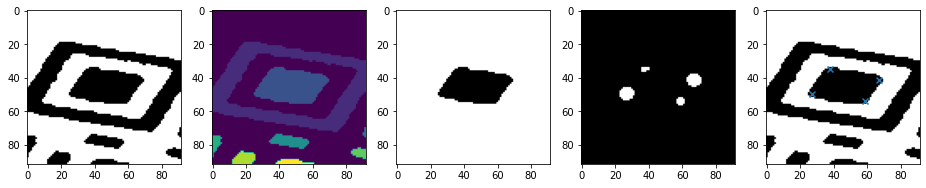

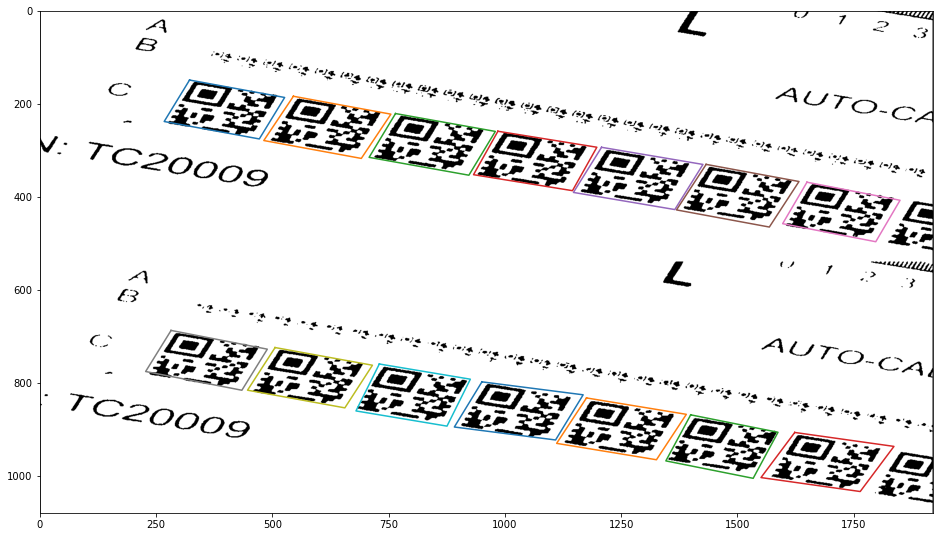

In [7]:
fig,axs = plt.subplots(1,5, figsize=(16,16))
axs[0].imshow(sub_I, cmap='gray')
axs[1].imshow(label_sub_I)
axs[2].imshow(center_cc, cmap='gray')
axs[3].imshow(corner_sub_I>1., cmap='gray')
scatter_x = [ x for x,y in corners ]
scatter_y = [ y for x,y in corners ]
axs[4].imshow(sub_I, cmap='gray')
axs[4].scatter(scatter_y,scatter_x, marker='x')

fig,axs = plt.subplots(1,1, figsize=(16,16))

axs.imshow(I, cmap='gray')

for Pp_I in BBox:
    scatter_x = [ x for x,y in Pp_I ] + [Pp_I[0][0]]
    scatter_y = [ y for x,y in Pp_I ] + [Pp_I[0][1]]
    axs.plot(scatter_y,scatter_x,)

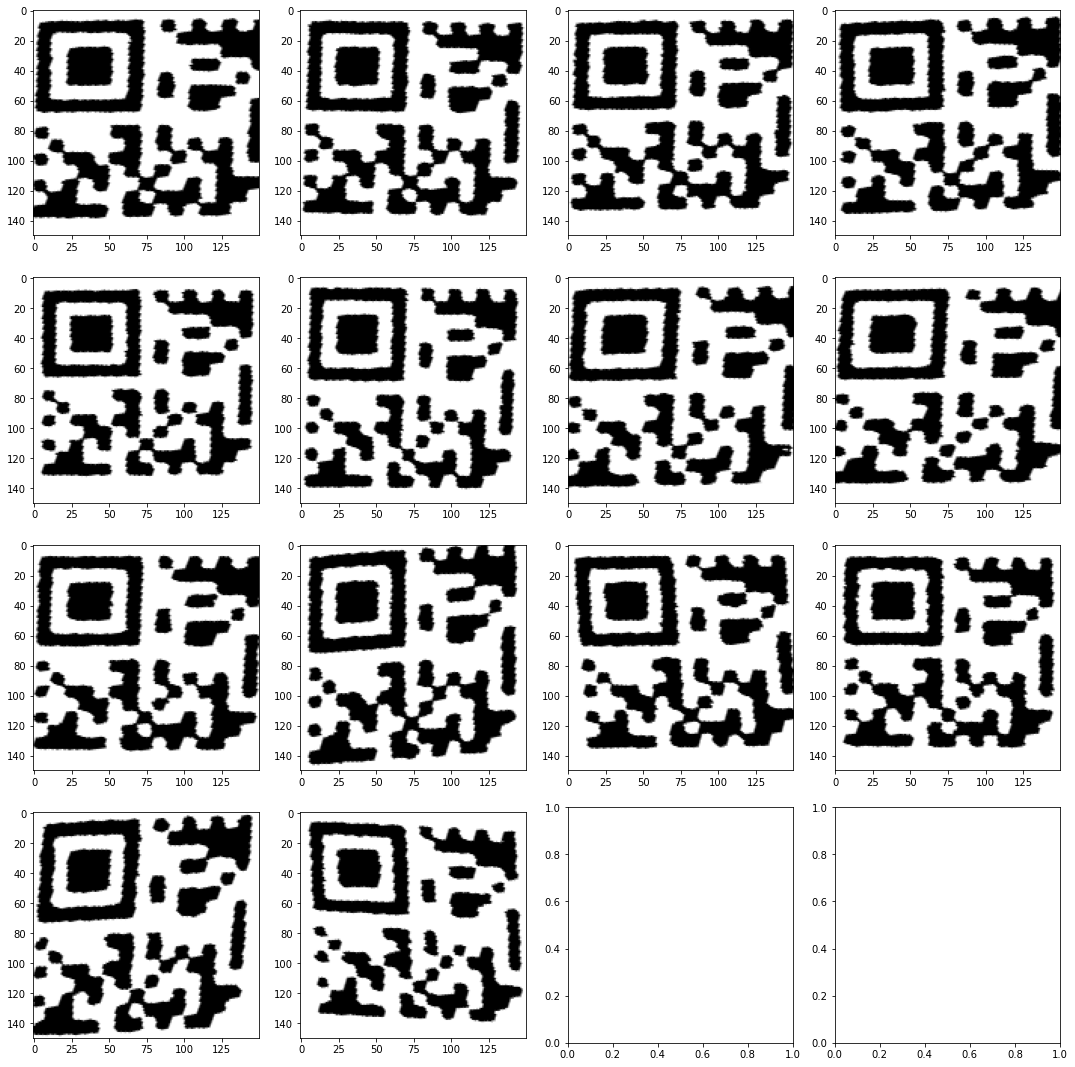

In [8]:
# Check results

N = len(BBox)
fig,axs = plt.subplots(N//4+1,4, figsize=(15,15))
s = 150
projection = np.array([[0, 0],
                      [s, 0],
                      [s, s],
                      [0, s]])
points_of_interest = np.zeros([4,2])
for i in range(N):

    points_of_interest[:,0] = BBox[i][:,1]
    points_of_interest[:,1] = BBox[i][:,0]

    tform = transform.estimate_transform('affine', points_of_interest, projection)

    tf_img_warp = transform.warp(I, tform.inverse, mode = 'constant', output_shape=[s,s])
    axs[i//4,i%4].imshow(tf_img_warp, cmap='gray')

plt.tight_layout()

## Questions

1) How this can be used?
    1) It can be used to share internet links in advertisement os as augmented reality (AR) tags show multimedia content on smarphones.
2) What type of code is this one?
    1) A quick response (QR) code: it is an extension of the bar code as it can hold more information within a 2d matrix structure, infact a QR code may encode not only 8 bit alphanumeric characters but also kanji characters.
    It also includes a finder pattern at each corner so that cameras can be used as scanners.
3) How you would implement the recognition and decoding of this code
    1) The QR code represent a bright and dark pattern wich can be interpreted as 1 and 0. Once detected these can be rectified to match a regular grid and subsequently read. Once the information has been read it can be decoded into 
    characters.

# Observations

1) These codes lie all on the same surface, with this knowledge one could implement a more precise detector as all patterns are distorted by a single plane transfomation.
2) Normally QR codes have more finders patterns to determine boundaries, this one has 4 dots at the top of the leftmost block and 4 dots to the left of the bottom block, maybe these could have been 
   used to detect the boundaries more efficiently but idk if these are part of the message.